# Data scientist workflow

Let's begin a full data scientist workflow on a simplified use case. 

**Situation**: Today Thermal Models (also called TMM: Thermal Mathematical Models) are very (very) slow - order of magnitude: 1 hours per simulation. For a complete thermal analysis, thousand of simulations have to be launch, to test the various space environment (test the different manoevers, on various date of the year, with various equipement ON/OFF...). 

Your purpose is to propose a Machine learning model permitting to *emulate* the TMM with a drastically reduced computing time.

**Chalenge**:
1. Find a Machine learning model which *emulate* the best TMM behaviour. More precisely, you have to propose an ML model with error < 1°.
2. Your model shall be run a simulation on a reasonable computing time: < 1 second for one orbit simulated.

**TMM used**: You will use a simplified model. This model is composed by a satellite with 45 thermal nodes (45 temperatures are outputed by the model). 

![img/train_sat.png](img/train_sat.png)
*Illustration: the satellite used. Left: external model, right internal model.*

* 9 TMM Input: 

    * 6 dissipation parameters: in [0.1, 2]
        * QI_BATTERY: dissipation of the battery 
        * QI EPC: dissipation of the EPC: Electronic Power Converter
        * QI_OMUX: dissipation of the OMUX: Output Multiplexer
        * QI_PCDU: dissipation of the PCDU (Power Conditioning and Distribution Unit)
        * QI_TRANSPONDER: dissipation of the transponder
        * QI_TWT: Dissipation of the Travelling Wave Tube (repeater)
    * 3 coupling parameters: in [0.1 ; 5]
        * Wall_MLI: Coefiscient of heat insulation of the MLI (Multi Layer Insulation)
        * Wall_Units: Coeffiscient of heat transfert between the equipements and the wall  
        * Wall_Wall: : Coeffiscient of rejection of heat between the wall and space (measure efficiency of the heat pipes).


* TMM Output: 45 Temepratures (one per node).

**Work**:
1. Generate data
2. Pre-process data (train test split, ...)
3. Choose a reference model and a loss function
4. Choose and train your ML model
5. Evaluate models (scores, comparison to reference, robustness, ...)
6. [facultative] Optimize the hyper-parameters of your models

In [1]:
# import sys
# sys.path.append("C:\\Unsuported\\miniconda\\lib\\site-packages")

**Import usefull libs here**

In [2]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Usefull
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Linear model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# XGBoost
from xgboost import XGBRegressor

# Gaussian process
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared, ConstantKernel

# Other usefull models
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

# Hyper-parameters tunning
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# 0/ Generate data

**General confs**

In [3]:
filename_input = "data/input_df.pickle"
filename_outputs = "data/target_df.pickle"

**Read data**

In [4]:
# Read filename containing the inputs...
with open(filename_input, 'rb') as f:
    df_in = pickle.load(f)
    
# ... and the outputs
with open(filename_outputs, 'rb') as f:
    df_out = pickle.load(f)

    
df_in.head()

,PASTA_QI_BATTERY,PASTA_Wall_Units,PASTA_QI_EPC_2,PASTA_Wall_MLI,PASTA_QI_EPC_1,PASTA_QI_OMUX,PASTA_QI_TWT_1,PASTA_QI_TWT_3,PASTA_QI_TWT_2,PASTA_Wall_Wall,PASTA_QI_TRANSPONDER,PASTA_QI_PCDU
0,1.870325,1.184125,0.777825,1.179225,1.440925,0.940275,1.201525,1.201525,1.356375,2.551225,0.143225,1.676525
1,1.971025,2.855025,1.344025,0.174725,0.691375,0.379775,0.788275,0.182175,0.336075,0.414825,1.561575,1.254725
2,0.843375,0.936675,0.419675,4.802775,0.758825,1.950125,1.458975,0.780675,0.246775,2.708025,1.350675,1.014375
3,1.076125,0.145325,0.569775,1.125325,1.312675,0.305675,1.057125,0.925075,0.225875,1.260075,0.689475,0.473825
4,0.224925,0.627975,0.251525,4.682725,1.238575,1.140725,0.877575,1.578675,0.959275,3.171075,0.328475,1.340225


In [5]:
df_out.head()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.585262,0.249293,0.472491,-83.528588,-8.160093,5.864144,-7.537267,-0.048408,-0.158241,-27.835833,...,-6.664121,3.337633,-8.187552,5.861442,5.907546,4.974770,5.690321,13.405953,0.214319,-269.0
1,-14.613094,-14.685090,-14.615978,-89.434313,-8.693956,5.723891,-8.038863,-2.122593,-2.247297,-31.405410,...,-6.779252,-12.103158,-8.297227,-13.320579,-13.161429,-13.503402,-13.388609,-11.923739,-14.719540,-269.0
2,-2.143549,-2.334472,-2.289555,-69.535581,-6.872346,5.905495,-6.306220,5.988950,5.912764,-21.347818,...,-6.645850,3.547170,-8.172784,5.530462,6.170057,2.500808,5.401711,19.595199,-2.470153,-269.0
3,-20.933235,-21.446717,-20.672376,-85.851042,-8.938915,5.064622,-8.293942,-3.251924,-3.366221,-30.672095,...,-7.067188,-15.265375,-8.528952,-17.434262,-16.981484,-18.611641,-17.500226,-14.220339,-21.843306,-269.0
4,-10.009082,-10.501594,-10.484316,-72.313948,-8.006780,4.765021,-7.431737,1.437174,1.356736,-24.497453,...,-7.151838,-3.321060,-8.582588,-3.145854,-2.374901,-6.357316,-3.206546,7.650647,-10.594908,-269.0


**Pre-process data: Clean**

In [6]:
# Drop the last column (contains the node "space", always at -269°C)
df_out = df_out.drop(columns=44)
df_out.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.585262,0.249293,0.472491,-83.528588,-8.160093,5.864144,-7.537267,-0.048408,-0.158241,-27.835833,...,3.430053,-6.664121,3.337633,-8.187552,5.861442,5.907546,4.974770,5.690321,13.405953,0.214319
1,-14.613094,-14.685090,-14.615978,-89.434313,-8.693956,5.723891,-8.038863,-2.122593,-2.247297,-31.405410,...,-12.037574,-6.779252,-12.103158,-8.297227,-13.320579,-13.161429,-13.503402,-13.388609,-11.923739,-14.719540
2,-2.143549,-2.334472,-2.289555,-69.535581,-6.872346,5.905495,-6.306220,5.988950,5.912764,-21.347818,...,3.639984,-6.645850,3.547170,-8.172784,5.530462,6.170057,2.500808,5.401711,19.595199,-2.470153
3,-20.933235,-21.446717,-20.672376,-85.851042,-8.938915,5.064622,-8.293942,-3.251924,-3.366221,-30.672095,...,-15.204713,-7.067188,-15.265375,-8.528952,-17.434262,-16.981484,-18.611641,-17.500226,-14.220339,-21.843306
4,-10.009082,-10.501594,-10.484316,-72.313948,-8.006780,4.765021,-7.431737,1.437174,1.356736,-24.497453,...,-3.240738,-7.151838,-3.321060,-8.582588,-3.145854,-2.374901,-6.357316,-3.206546,7.650647,-10.594908


**Pre-process data: Transform into Numpy DataFrame**

More convenient for data manipulation

In [7]:
np_in, np_out = df_in.values, df_out.values

# 1/ Exercice 1: Pre-process data

**Purpose of the exercice:**: Find in autonomy the better way to pre-process data.

**Instructions**:
1. Split data into *train* and *test* sample. You can use the sklearn `train_test_split` to do that. (just search on Google)
2. *Scale* your data using the sklearn `StandardScaler` (just google it)
3. Analyse the data: plot values of T° for node 14 before and after scaling.

*Important note about scaling*: 
A scaler works in two steps: 
1. `fit`: compute statistics on the distribution (e.g. the average and std values of the dataset for `StandardScaler`)
2. `transform`: effectively apply the operation of scaling (e.g. substract by average value and divide by std).

The operation 1. (`fit`) must be performed on **Train** data only to get sure no information of the **validation** sample is used.

### 1.1 Train test split to avoid overtraining

In [8]:
## SOLUTION

# Split into two dataset: 80% training / 20% test.
X_train, X_test, y_train, y_test = train_test_split(np_in, np_out, test_size=0.20, random_state=42)

NB: `train_test_split` also shuffle data.

### 1.2 Scaling

We choose to scale the data. It is a process often used to "help" the models prediction (better scores when trained on scaled data). 

In this BE, we choose to use `StandardScaler`. See [this post](https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler) for explanations.

Note that the scaler is fitted on **train** data only. We are sure that no information is transmitted between train and test.

In [9]:
## SOLUTION

# The input AND the output shall be scaled. 
# ---------------------------------------------

# 1/ Scale the inputs
# ---------------------------
scaler_in = StandardScaler()

# compute min and max on the TRAIN sample only -> we are sure that no information is transmitted between train and test.
X_train_scaled = scaler_in.fit_transform(X_train)  
X_test_scaled = scaler_in.transform(X_test)

# 2/ Scale the outputs
# ---------------------------
scaler_out = MinMaxScaler()

y_train_scaled = scaler_out.fit_transform(y_train)
y_test_scaled = scaler_out.transform(y_test)

To apply the unscaling operation, just apply `scaler_out.inverse_transform(y_data_to_unscale)`.

### 1.3. Analyze your data

Let's visualize the scaling effect.

In [10]:
# Visualize the scaling effect on node:
node_id = 14

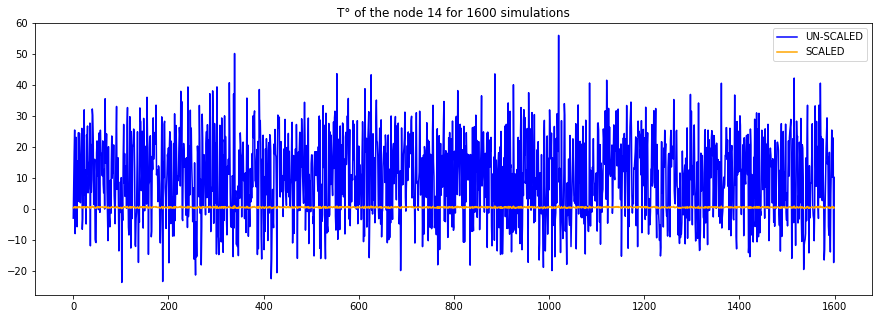

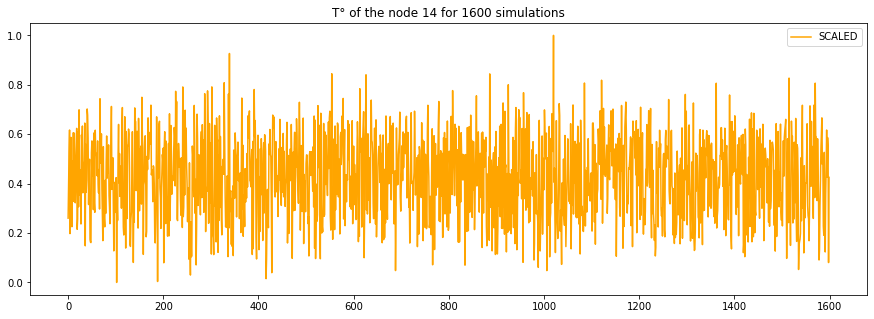

In [11]:
## SOLUTION

plt.figure(figsize=(15, 5))

# 1/ Un-scaled VS Scaled
plt.plot(y_train[:, node_id], label="UN-SCALED", color="b")
plt.plot(y_train_scaled[:, node_id], label="SCALED", color="orange")
plt.title(f"T° of the node {node_id} for 1600 simulations")
plt.legend()
plt.show()

# 2/ Scaled only
plt.figure(figsize=(15, 5))
plt.plot(y_train_scaled[:, node_id], label="SCALED", color="orange")
plt.title(f"T° of the node {node_id} for 1600 simulations")
plt.legend()
plt.show()



As you can see, scaled data ranges between 0 and 1. 

**Usefull function**

Here is a usefull function to analyse your data. It permits to show the distribution of values for each node.

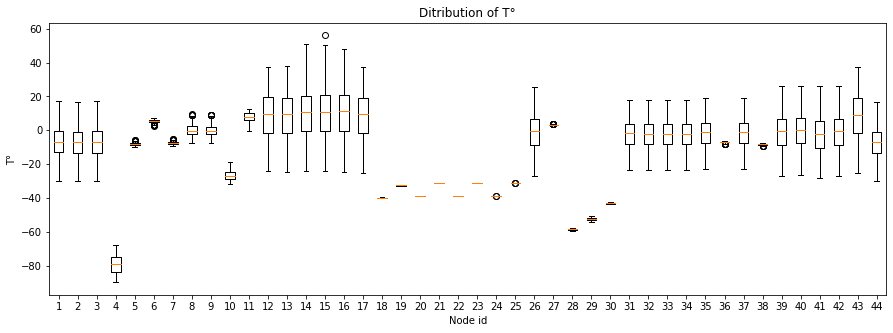

In [12]:
plt.figure(figsize = (15, 5))

plt.boxplot(y_train)
plt.title("Ditribution of T°")
plt.xlabel("Node id")
plt.ylabel("T°")
plt.show()

# 2/ Choose the cost function

Choose the criterion of evaluation of your model. 

In [13]:
# List of criterions:


def compute_quality_criterions(y_pred, y_ref):
    """
    Compute all the criterion of quality of your prediction. 
    Permits to efficiently compare models quality regarding multiple criterions.
    
    :return: dict containing:
        * Key: name of the criterion
        * Value: Value of the criterion
    """
    return {"mae": mean_absolute_error(y_pred, y_ref), # mean absolute error
            "mse": mean_squared_error(y_pred, y_ref),  # mean squared error
            "std": np.std(y_pred - y_ref).mean(),  # standard deviation 
            "max_absolute_error": np.max(np.max(np.abs(y_pred - y_ref))),  # maximal absolute error 
           }

def print_quality_criterion(y_pred, y_ref):
    """
    Display the quality criterions.
    """    
    d = compute_quality_criterions(y_pred, y_ref)
       
    for k, v in d.items():
        # ex: mae: 0.1
        print(f"{k}: {v:.1f}")  # .1f: 1 digit after coma       



Do not forget to unscale your data BEFORE applying the criterion (else, no sense).

# 3/ Reference model

Choose a naive model permitting to have a reference.

In this section, I show you an example of code to reproduce. The only element to modify is the model choosen (line `model = ...`).

### 3.1. Linear regression

In [14]:
# Define the model to use
model = LinearRegression()

# Train the model
model.fit(X_train_scaled, y_train_scaled)

LinearRegression()

### 3.2. Evaluate quality of the *reference* model

In [15]:
# Evaluate the model on the validation sample
y_pred_scaled = model.predict(X_test_scaled)

# Un-scale the prediction (remember, X and y are scaled !)
y_pred = scaler_out.inverse_transform(y_pred_scaled)

mae: 0.7
mse: 1.7
std: 1.3
max_absolute_error: 26.0


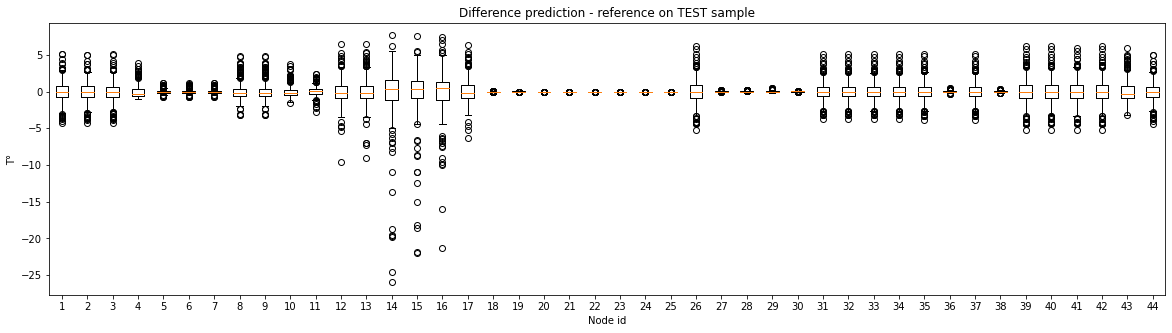

In [16]:
# Display the scores on this model
print_quality_criterion(y_pred, y_test)

# Plot the dispertion of errors for each node.
plt.figure(figsize=(20,5))

plt.title("Difference prediction - reference on TEST sample")
plt.xlabel("Node id")
plt.ylabel("T°")
plt.boxplot(y_pred - y_test)
plt.show()

**Bilan**: Ok, the linear regression model is very bad. 

But we have our reference. Let's try now to do a better job.

# 4/ Exercice 2: Benchmark ML models


**Purpose of the exercice:** This is the main exercice. Purpose is to test multiple machine learning models and compare them. Through this exercice, I want to show you a realistic example of how a data science work requires engineering.

**Instructions:**
1. Code your own function containing the full workflow (train, predict, `print_quality_criterion`, display boxplots)

Test this function on various ML models, I have choosen various models from the litterature. **Of course, this work have to be performed by the Data scientist** (not enought time in this BE).

2. xgboost (see `XGBRegressor` on Google)
3. Gaussian Process (see `GaussianProcessRegressor` on Google)
4. *[More difficult]* Polynomial regression (Use the sklearn `PolynomialFeatures`). If it's too difficult, see answer in [this stack overflow post](https://stackoverflow.com/questions/54891965/multivariate-polynomial-regression-with-python).
5. *[Facultative]*: Test other ML approaches. You can find [here](https://scikit-learn.org/stable/supervised_learning.html) the regression models available on sklearn
6. *[Facultative]*: Test Multi-Layer Perceptron
    



### 4.1 Build your workflow function

In [17]:
## SOLUTION


def evaluate_predictions(y_pred):
    """
    Evaluate predictions of a model. Plot elements and display scores.
    
    :param y_pred: Results from `model.predict(y_test)` (after unscaling)
    """
    plt.figure(figsize=(20,5))

    plt.title("Difference prediction - reference on TEST sample")
    plt.xlabel("Node id")
    plt.ylabel("T°")

    print_quality_criterion(y_pred, y_test)
    plt.boxplot(y_pred - y_test)
    plt.show()


def train_evaluate(model, scaled=True):
    """
    Use this function to benchmark a model.
    
    Launch a training using `model` and an evaluation (incl. plots).
        
    :param model: Model used for training. Use an sklearn type model (with `fit`, `predict` functions).
    :param scaled: Bool indicating if (case True) data shall be scaled for training. Note that results show UNSCALED data.
    """
    if scaled:
        x_tr = X_train_scaled  #  train
        y_tr = y_train_scaled  # train
        x_va = X_test_scaled  # valid
        y_va = y_test_scaled  # valid
    else:
        x_tr = X_train
        y_tr = y_train
        x_va = X_test
        y_va = y_test
    
    
    # 1/ Train model 
    # ---------------------
    model.fit(x_tr, y_tr)
    
    # 2/ Evaluate model on validation sample
    # --------------------------------------------
    # predicting on test data
    y_pred = model.predict(x_va)
    
    # Un scale results if necessary
    if scaled:
        y_pred = scaler_out.inverse_transform(y_pred)

    # 3/ Plot evaluation
    # --------------------------------------------
    evaluate_predictions(y_pred)

### 4.2 XGBOOST

XGBoost is a technique of ML using trees. Read [this doc](https://medium.com/analytics-vidhya/introduction-to-xgboost-algorithm-d2e7fad76b04) for a gentle introduction, and [this one](https://xgboost.readthedocs.io/en/stable/tutorials/model.html) for a details. 

![img/xgboost.png](img/xgboost.png)

*Illusration of the XGBoost prediction:*

**XGBoost without scaling**

mae: 0.7
mse: 1.7
std: 1.3
max_absolute_error: 16.8


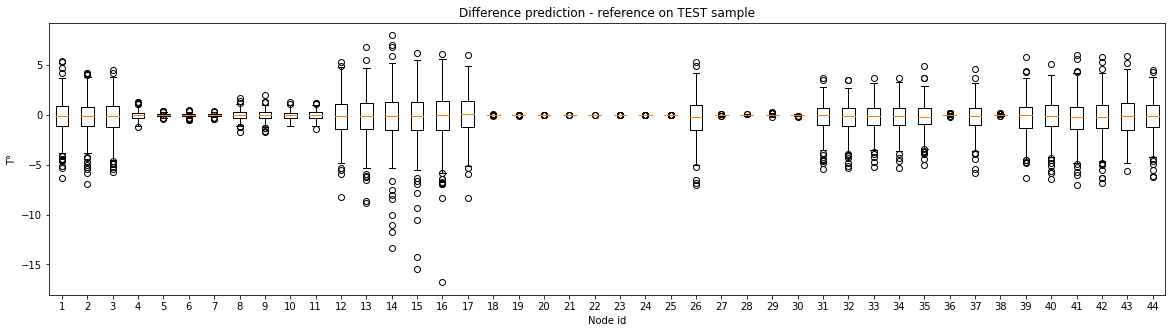

In [18]:
## SOLUTION

# Define the model
xgbr = XGBRegressor(verbosity=0)

# Train and evaluate
train_evaluate(model=xgbr, scaled=False)

**XGBoost with scaling**

mae: 0.7
mse: 1.7
std: 1.3
max_absolute_error: 18.0


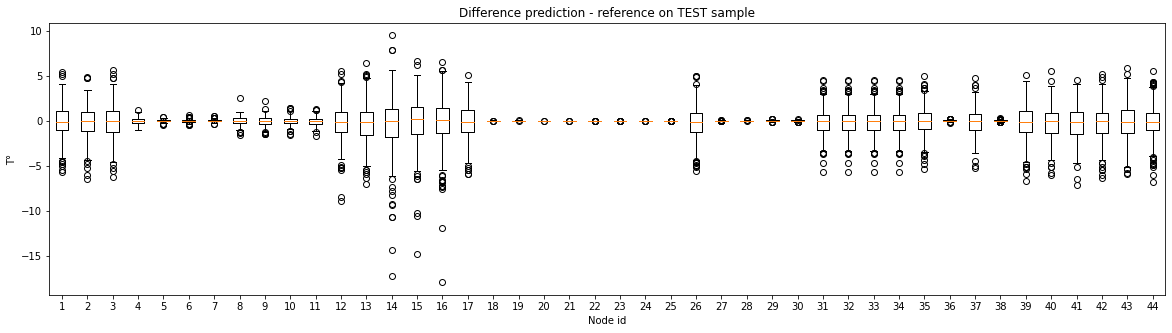

In [19]:
## SOLUTION

# Define the model
xgbr = XGBRegressor(verbosity=0)

# Train and evaluate
train_evaluate(model=xgbr, scaled=True)

### 4.3/ Gaussian process

Find a very good introduction to Gaussian Process here: https://distill.pub/2019/visual-exploration-gaussian-processes/.

In a nutshell, GPs (Gaussian Processes) are a mixture of gaussian estimator. 

![img/gaussian_process.png](img/gaussian_process.png)

*Illustration of a Gaussian process regression*

**Gaussian Process without scaling**

mae: 4.0
mse: 41.9
std: 6.3
max_absolute_error: 52.0


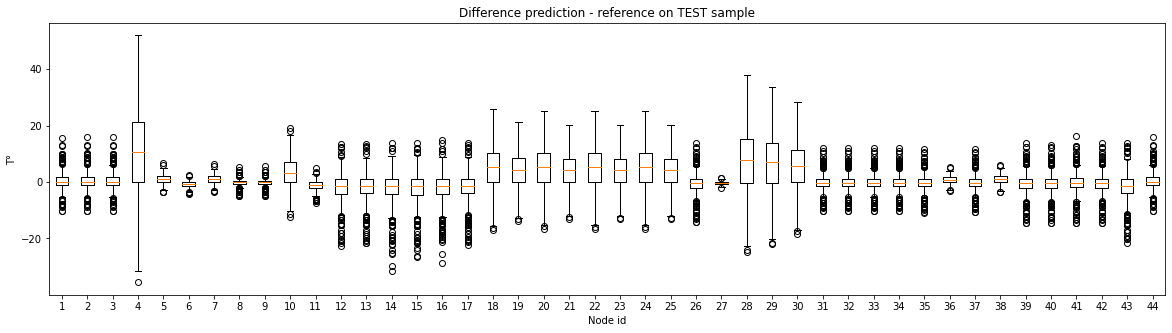

In [20]:
## SOLUTION

gp = GPR()

# Train and evaluate
train_evaluate(model=gp, scaled=False)

**Gaussian Process with scaling**

mae: 7.9
mse: 160.5
std: 10.1
max_absolute_error: 67.8


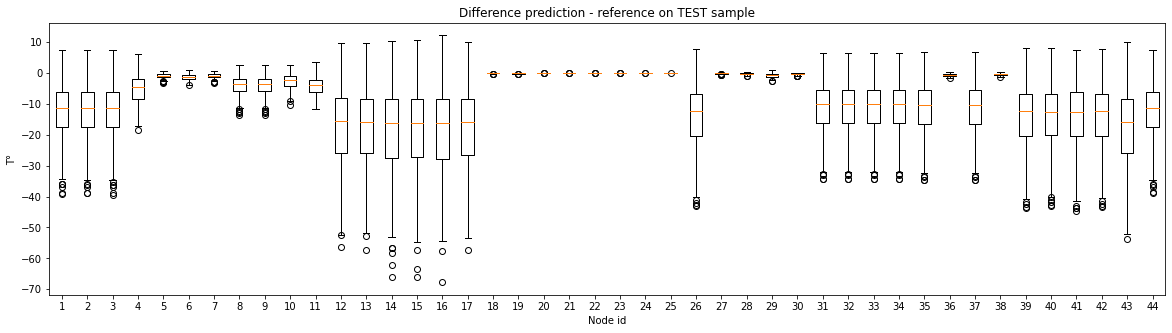

In [21]:
## SOLUTION

gp = GPR()

# Train and evaluate
train_evaluate(model=gp, scaled=True)

### 4.4/ Polynomial regression

If you are blocked, see [this stackoverflow post](https://stackoverflow.com/questions/54891965/multivariate-polynomial-regression-with-python).

Power 3
mae: 0.1
mse: 0.3
std: 0.2
max_absolute_error: 20.9


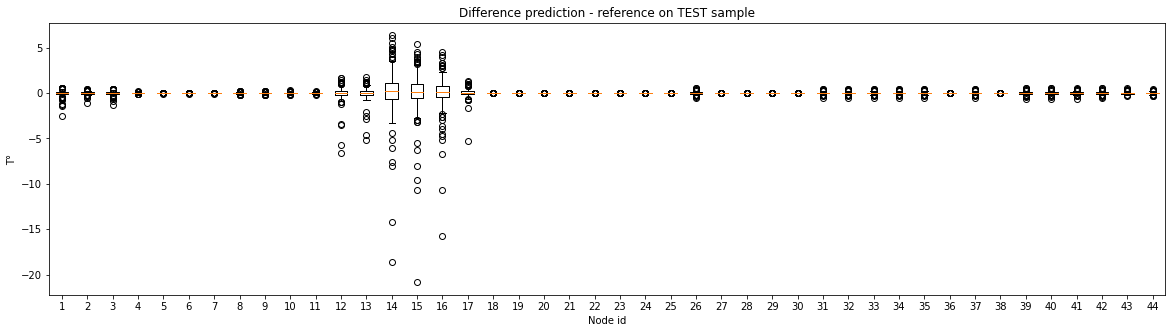

In [22]:
## SOLUTION

POLYNOM_DEGREE = 3

# 1/ Train
poly = PolynomialFeatures(degree=POLYNOM_DEGREE)
# 2/ Transform input data
poly_variables = poly.fit_transform(df_in)
# 3/ Split into train / test sample
poly_var_train, poly_var_test, poly_y_train, poly_y_test = train_test_split(poly_variables,
                                                                            df_out,
                                                                            test_size = 0.2,
                                                                            random_state = 4)
# 4/ Train
regression = LinearRegression()
model = regression.fit(poly_var_train, poly_y_train)

# 5/ Evaluate
y_pred = model.predict(poly_var_test)

# 6/ Plot: note that `evaluate_predictions` can not be used as train / valid sample has been modified
print(f"Power {POLYNOM_DEGREE}")
plt.figure(figsize=(20,5))
plt.title("Difference prediction - reference on TEST sample")
plt.xlabel("Node id")
plt.ylabel("T°")
print_quality_criterion(y_pred, poly_y_test)
plt.boxplot(y_pred - poly_y_test)
plt.show()



### 4.5/ Other models


Test other ML approaches. You can find [here](https://scikit-learn.org/stable/supervised_learning.html) the regression models available on sklearn.

**Random Forest**

mae: 1.0
mse: 3.2
std: 1.8
max_absolute_error: 30.2


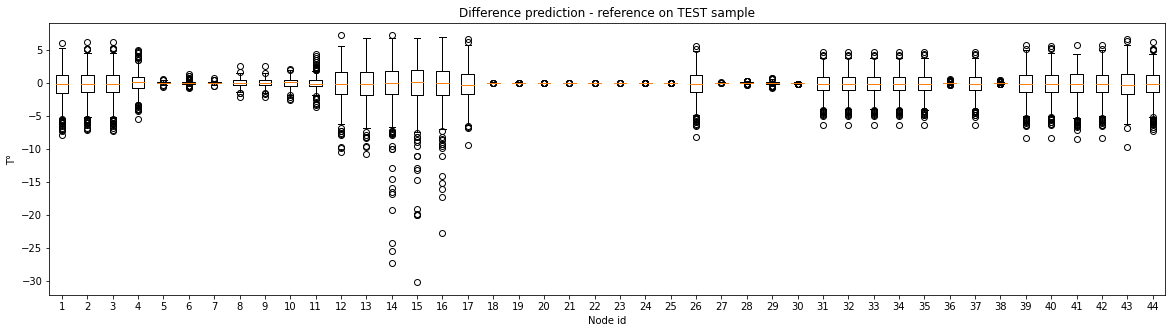

In [23]:
## SOLUTION

# Random forest
train_evaluate(model=RandomForestRegressor(), scaled=False)

**MultiOutputRegressor**

You may want to test models specialized in each feature (here, build 44 models, one per node). This (naive) approach is usefull to test sklearn models managing single outputs.

Detailes [here](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html).

mae: 1.2
mse: 4.5
std: 2.1
max_absolute_error: 19.4


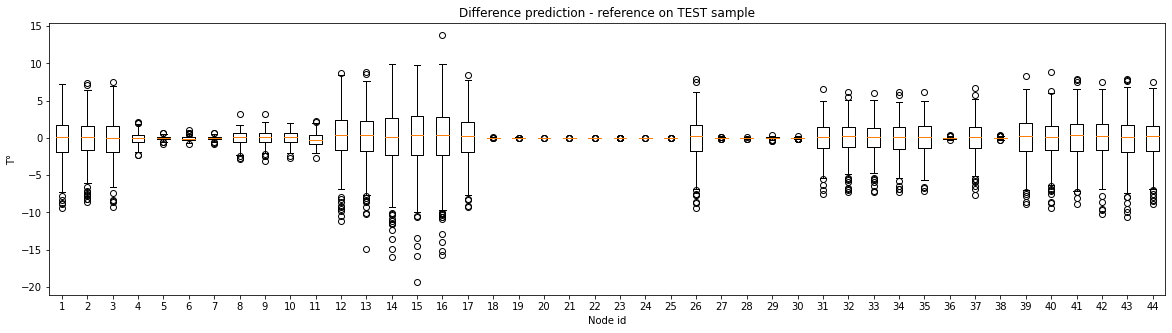

In [24]:
## SOLUTION

egr = MultiOutputRegressor(AdaBoostRegressor())

train_evaluate(model=egr, scaled=False)


mae: 1.1
mse: 4.4
std: 2.1
max_absolute_error: 21.3


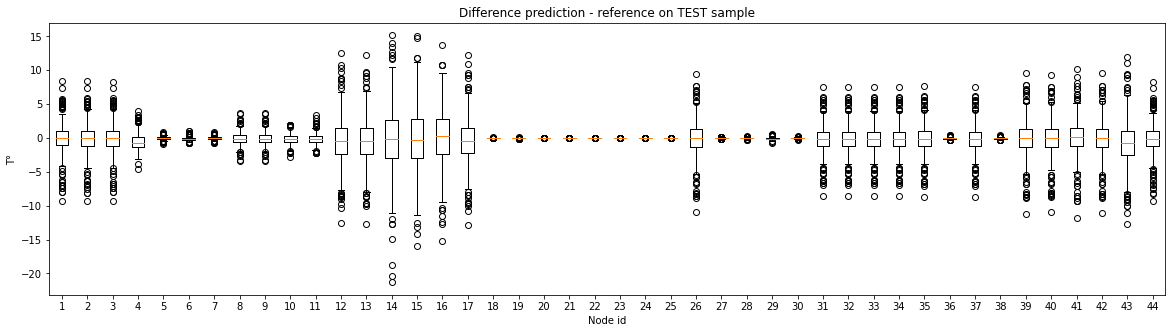

In [25]:
## SOLUTION

svm = MultiOutputRegressor(SVR())

train_evaluate(model=svm, scaled=True)

### 4.6/ Multi-Layer Perceptron

This is an introduction to MLP. If you are begining with Neural Network, we advise to use the [Keras](https://www.tensorflow.org/tutorials/keras/regression?hl=fr#regression_with_a_deep_neural_network_dnn) framework.

Keras is part of the Tensorflow project (Google): one of the main Neural Network library for Python. The other main Neural Network library is [pytorch](https://pytorch.org/). 

In [26]:
# Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# 1/ Define your network
# ---------------------------

# Initiate the network in "sequential" mode
model = Sequential() 

# Layer 1
model.add(Dense(30, input_shape=(X_train.shape[1],)))  # input shape must be specified in layer 1
# X_train.shape[1] = 12 -> 12 parameters in input of the network

# Layer 2, 3, ... (one line per layer)
model.add(Dense(20))
model.add(Dense(5))
model.add(Dense(30))

# Last layer shall predict 45 Temperatures (`y_train.shape[1]`: nb of columns of the outputs (T°))
model.add(Dense(y_train.shape[1]))

# 2/ Compile model
# ---------------------------
# This command "compile" the model, creating the C++ graph of computation.
# Also permits to choose some hyper-parameters
model.compile(loss='mean_squared_error',  # Choose the cost function (here MSE)
              optimizer='adam',  # choose the optimization algorithm used (here ADAM: state of the art)
              )

# 3/ Display layering of your network
# ---------------------------
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                390       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                180       
_________________________________________________________________
dense_4 (Dense)              (None, 44)                1364      
Total params: 2,659
Trainable params: 2,659
Non-trainable params: 0
_________________________________________________________________


Epoch 1/60
50/50 [==============================] - 0s 5ms/step - loss: 0.2965 - val_loss: 0.1450
Epoch 2/60
50/50 [==============================] - 0s 1ms/step - loss: 0.0545 - val_loss: 0.0134
Epoch 3/60
50/50 [==============================] - 0s 1ms/step - loss: 0.0087 - val_loss: 0.0061
Epoch 4/60
50/50 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 5/60
50/50 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 6/60
50/50 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 7/60
50/50 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/60
50/50 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 9/60
50/50 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/60
50/50 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 11/60
50/50 [

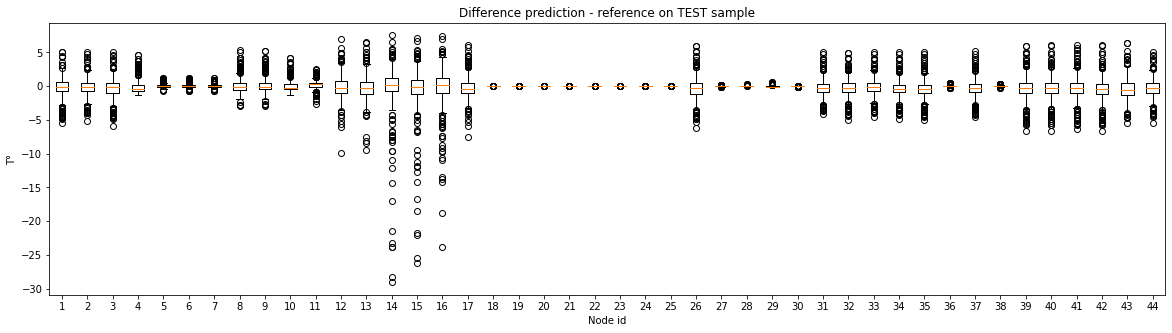

In [27]:
# 4/ Train model
# ---------------------------
model.fit(X_train_scaled,
          y_train_scaled,
          epochs=60,  # Number of iteration of the training algorithm
          validation_data=(X_test_scaled, y_test_scaled),
          verbose=1  # verbosity of the logs: 0 for no message
         )

# 5/ Validate
# ---------------------------
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_out.inverse_transform(y_pred_scaled)

evaluate_predictions(y_pred)

# 5/ Execrice 3: Optimize your model

You have found some interesting models. But you have tested it in default configuration... Each models have several parameters (e.g. `n_estimators, max_depth, min_child_weight...` for XGBOOST). You can modify these parameters to see if it's increase (or decrease) the performance. This process is called **hyper-parameters tunning**. It is a mandatory step in the data scientist workflow.

**Purpose of the exercice:** Test tools to search the better set of hyper-parameters.

**Instructions:**
1. From an example of code, optimize manually the XGBOOST model proposed. 
2. Evaluate in a loop Polynom model from degree 2 to degree 5
3. Use the `RandomSearchCV` algorithm to automate the process
4. Use a state of the art algorithm (from `hyperopt` library) to select the better set of hyper-parameters

Find the best model !

### 5.1/ Tune manually an XGBoost model

Here are all the hyper-parameters of the XGBoost. Try to find manually the best set of hyper-parameters. Find [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) the list of available hyper-parameters.

mae: 2.9
mse: 22.8
std: 4.8
max_absolute_error: 32.0


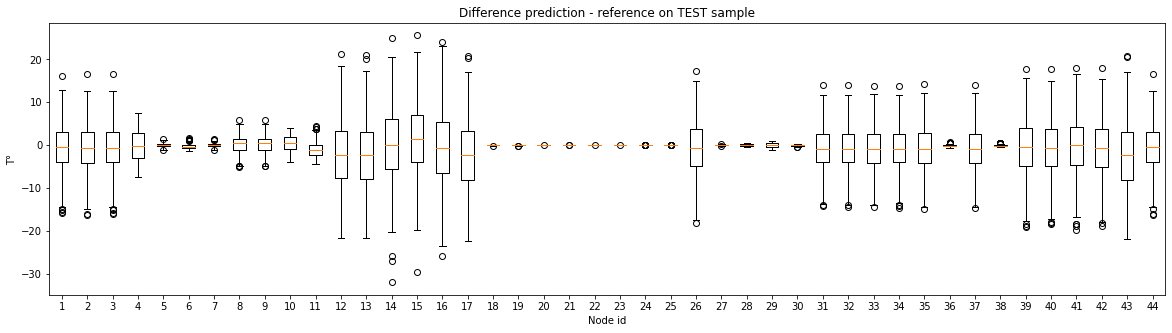

mae: 9.0
mse: 145.3
std: 10.9
max_absolute_error: 44.1


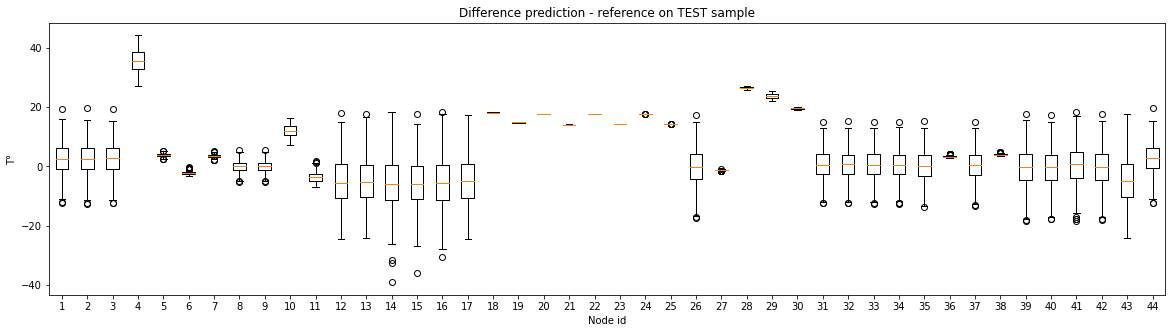

In [28]:
xgbr = XGBRegressor(max_depth= 6,  # maximum depth of the trees estimators
                    gamma=0.1,  # min loss reduction required to create a new leaf
                    learning_rate=0.004,  # Learning rate of the optim. algorithm
                    n_estimators=200,  # Number of trees
                    subsample=0.7,  # % of the training 
                    colsample_bytree=0.7,  # % of cols used to construct each tree
                    verbosity=1  # do not touch this (level of logs)
                   )

# Test with and without scaling
train_evaluate(model=xgbr, scaled=True)

train_evaluate(model=xgbr, scaled=False)

### 5.2/ Test multiple polynom degree

On step toward automation: test all polynom from degree 2 to degree 5. 

Power 2
mae: 0.2
mse: 0.4
std: 0.3
max_absolute_error: 24.7


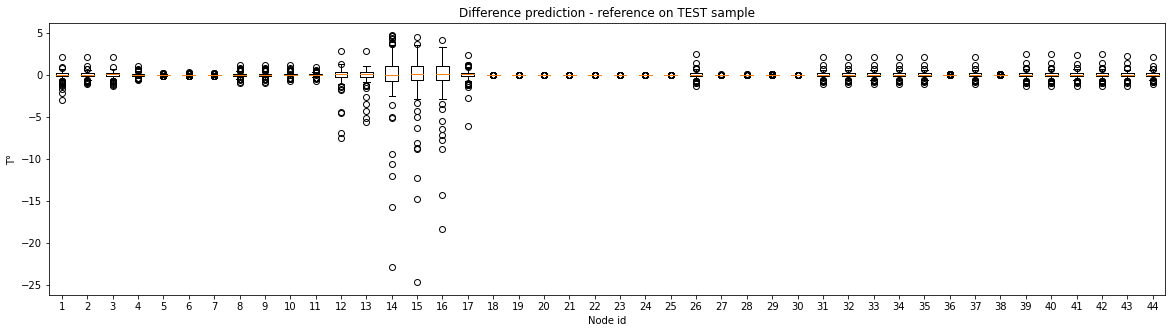

Power 3
mae: 0.1
mse: 0.3
std: 0.2
max_absolute_error: 20.9


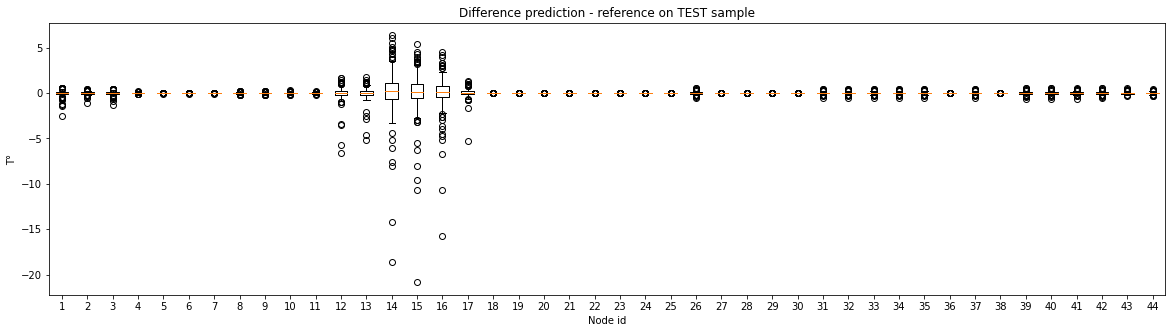

Power 4
mae: 0.6
mse: 2.3
std: 0.8
max_absolute_error: 32.7


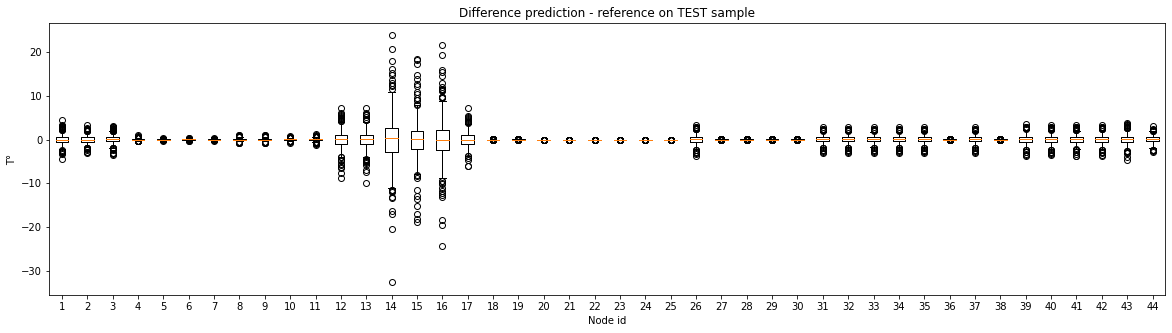

Power 5
mae: 1.4
mse: 7.7
std: 2.0
max_absolute_error: 33.1


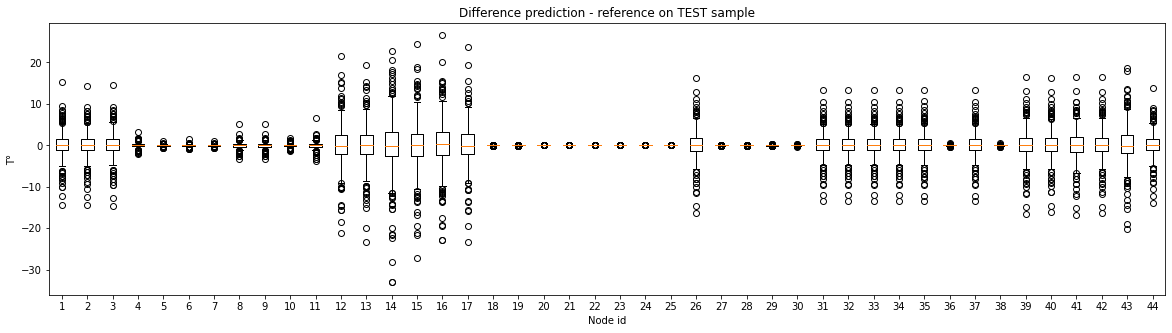

In [29]:
## SOLUTION

# Let's try to find the best reference model
for p in range(2, 6):  # test linear regression from power 2 to power 5

    # 1/ Train
    poly = PolynomialFeatures(degree=p)
    poly_variables = poly.fit_transform(df_in)
    poly_var_train, poly_var_test, poly_y_train, poly_y_test = train_test_split(poly_variables,
                                                                                df_out,
                                                                                test_size = 0.2,
                                                                                random_state = 4)
    regression = LinearRegression()
    model = regression.fit(poly_var_train, poly_y_train)

    # 2/ Evaluate
    y_pred = model.predict(poly_var_test)

    print(f"Power {p}")
    plt.figure(figsize=(20,5))
    plt.title("Difference prediction - reference on TEST sample")
    plt.xlabel("Node id")
    plt.ylabel("T°")
    print_quality_criterion(y_pred, poly_y_test)
    plt.boxplot(y_pred - poly_y_test)
    plt.show()


### 5.3/ Automating Hyper-parameter search

**Basic approach**

You can automate the hyper-parameter tunning based on a very simple tool: `RandomSearchCV`. It consist in:

* A. Detail the list of parameters to tune (and their ranges of values)
* B. The algorithm will choose randomly set of hyper-parameters and evaluate the corresponding trained model
    * This action is done multiple times (`n_iter`)
    * A cross validation is performed to robustify the result 
    
![img/cv.png](img/cv.png)  
    
Some tips and tricks and doc [here](https://scikit-learn.org/stable/modules/grid_search.html#).

In [32]:
# Number of test to launch
NB_TRIAL = 3

# List of parameters to tune and their ranges
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'n_estimators': [100, 500, 1000],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
        }

Implement the tunning of hyper-parameters using the sklearn `RandomSearchCV` algorithm (google it). 

In [33]:
## SOLUTION

# Init model
model = XGBRegressor(seed = 20)

# 2. Launch Search
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   scoring='neg_mean_squared_error',
                                   n_iter=NB_TRIAL,
                                   verbose=1)
random_search.fit(X_train, y_train)

# 3. Print best model
print("Best parameters:", random_search.best_params_)
print("Lowest MSE: ", -random_search.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  3.6min finished


Best parameters: {'subsample': 0.7999999999999999, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
Lowest MSE:  0.5497373933335182


### 5.4/ Optimize hyper-parameters using `hyperopt`

You can use a dedicated library to tune your hyper-parameters. Algorithm available are based on optimization techniques. 

This [post](https://towardsdatascience.com/hyperopt-demystified-3e14006eb6fa) details a lot what is behind it. In a nutshell, it is an iterative research algorithm based Expected Improvement computation. 

From this piece of code, find the better hyper parameters of your best model.

In [34]:
# Code taken from: https://www.kaggle.com/code/merrickolivier/hyperopt-and-xgbregressor-bayesian-optimization/notebook

NB_TRIAL = 3


space = {'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),  # for a float value
         'max_depth': hp.randint('max_depth', 2, 7)  # for an integer value
        }

def hyperparameter_tuning(space):
    model = XGBRegressor(**space, verbosity=0)
    
    #Define evaluation datasets.
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    #Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(X_train,
              y_train,
              )

    #Obtain prediction and rmse score.
    pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    print ("SCORE:", rmse)
    
    #Specify what the loss is for each model.
    return {'loss':rmse, 'status': STATUS_OK, 'model': model}
         
         
#Run 20 trials.
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=NB_TRIAL,
            trials=trials)

print(best)

SCORE:                                                                                                                 
3.8207240695600335                                                                                                     
SCORE:                                                                                                                 
12.626039426926742                                                                                                     
SCORE:                                                                                                                 
1.4912489544196352                                                                                                     
100%|██████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.30s/trial, best loss: 1.4912489544196352]
{'learning_rate': 0.03535384484439227, 'max_depth': 5}


mae: 1.2
mse: 2.9
std: 1.7
max_absolute_error: 17.2


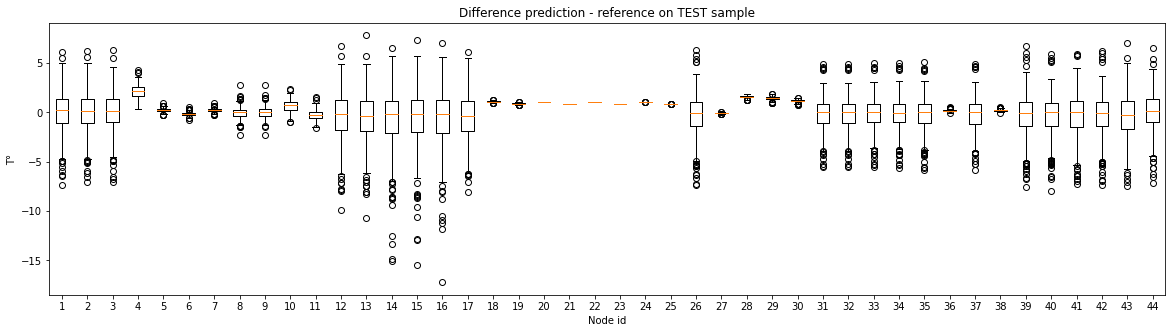

In [35]:
train_evaluate(XGBRegressor(**best), scaled=False)